In [1]:
cd ../src

/workspace/kaggle_otto_rs/src


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%load_ext lab_black

In [4]:
import os
import gc
import sys
import cudf
import json
import glob
import pickle
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime
from collections import Counter
from pandarallel import pandarallel
from numerize.numerize import numerize

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
warnings.simplefilter(action="ignore", category=FutureWarning)

pandarallel.initialize(nb_workers=8, progress_bar=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
from params import *
from utils.chris import *
from utils.metrics import *

## Matrix computation

In [6]:
# data_cache = {}
# type_labels = {"clicks": 0, "carts": 1, "orders": 2}
# files = glob.glob("../input/chris/*_parquet/*")

# for f in tqdm(files):
#     data_cache[f] = read_file_to_cache(f)

In [7]:
# clicks_candids = compute_covisitation_matrix(
#     files,
#     data_cache,
#     weighting="temporal",
#     n=15,
#     save_folder="../output/",
# )

In [8]:
# type_weighted_candids = compute_covisitation_matrix(
#     files,
#     data_cache,
#     weighting="type",
#     type_weight={0: 1, 1: 3, 2: 6},  # weird ?
#     n=20,
#     save_folder="../output/",
# )

In [9]:
# cartbuy_matrix_candids = compute_covisitation_matrix(
#     files,
#     data_cache,
#     considered_types=[1, 2],
#     weighting="",
#     n=20,
#     save_folder="../output/",
# )

### Val data

In [10]:
gt = pd.read_parquet("../input/chris/test_labels.parquet")

In [11]:
df_val = load_val()
df_val = df_val.sort_values(["session", "ts"]).reset_index(drop=True)

In [12]:
top_clicks = df_val.loc[df_val["type"] == 0, "aid"].value_counts().index.values[:20]

top_orders = df_val.loc[df_val["type"] == 2, "aid"].value_counts().index.values[:20]

### Chris

In [13]:
# clicks_candids = matrix_to_candids_dict(
#     cudf.read_parquet("../output/matrix_123_temporal_20.pqt")
# )
# type_weighted_candids = matrix_to_candids_dict(
#     cudf.read_parquet("../output/matrix_123_type_15.pqt")
# )
# cartbuy_matrix_candids = matrix_to_candids_dict(
#     cudf.read_parquet("../output/matrix_12__15.pqt")
# )

In [14]:
# %%time
# pred_df_clicks = df_val.groupby(["session"]).apply(
#     lambda x: suggest_clicks(x)
# )

In [15]:
# %%time
# pred_df_buys = df_val.groupby(["session"]).apply(
#     lambda x: suggest_buys(x)
# )

In [16]:
# %%time

# clicks_pred_df = pd.DataFrame(pred_df_clicks.add_suffix("_clicks"), columns=["labels"]).reset_index()
# orders_pred_df = pd.DataFrame(pred_df_buys.add_suffix("_orders"), columns=["labels"]).reset_index()
# carts_pred_df = pd.DataFrame(pred_df_buys.add_suffix("_carts"), columns=["labels"]).reset_index()

# pred_df = pd.concat([clicks_pred_df, orders_pred_df, carts_pred_df])
# pred_df.columns = ["session_type", "labels_l"]
# pred_df["labels"] = pred_df["labels_l"].apply(lambda x: " ".join(map(str, x)))

In [17]:
# score = 0
# weights = {'clicks': 0.10, 'carts': 0.30, 'orders': 0.60}
# for t in tqdm(['clicks','carts','orders']):
#     sub = pred_df.loc[pred_df.session_type.str.contains(t)].copy()
#     sub['session'] = sub.session_type.apply(lambda x: int(x.split('_')[0]))
#     sub.labels = sub.labels.apply(lambda x: [int(i) for i in x.split(' ')[:20]])

#     test_labels = gt.loc[gt['type']==t]
#     test_labels = test_labels.merge(sub, how='left', on=['session'])
#     test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
#     test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0, 20)

#     recall = test_labels['hits'].sum() / test_labels['gt_count'].sum()
#     score += weights[t]*recall
#     print(f'- {t} Recall :\t{recall:.4f}')

# print(f'\n -> CV Score : {score:.4f} ')

- clicks Recall :	0.5256
- carts Recall :	0.4096
- orders Recall :	0.6490

 -> CV Score : 0.5648 

In [18]:
# df_pred = pred_df[["session_type", "labels_l"]].copy()
# df_pred.columns = ["session_type", "candidates"]
# df_pred["session"] = (
#     df_pred["session_type"].apply(lambda x: x.split("_")[0]).astype(int)
# )
# df_pred["type"] = df_pred["session_type"].apply(lambda x: x.split("_")[1])

# df_pred = df_pred.merge(gt, on=["session", "type"], how="left")

# for col in CLASSES:
#     df_pred_c = df_pred[df_pred["type"] == col]

#     n_preds, n_gts, n_found = get_coverage(
#         df_pred_c["candidates"].values, df_pred_c["ground_truth"].values
#     )

#     print(
#         f"- {col}\t- Found {numerize(n_found)} GTs with {numerize(n_preds)} candidates (pos_prop={n_found / n_preds * 100 :.2f}%)"
#     )

- clicks	- Found 922.64K (52.56%) GTs with 35.74M candidates (pos_prop=2.58%)
- carts	- Found 236.14K (40.96%) GTs with 32.3M candidates (pos_prop=0.73%)
- orders	- Found 203.32K (64.90%) GTs with 32.3M candidates (pos_prop=0.63%)

## Candidates

In [19]:
df_val.head()

,session,aid,ts,type
0,11098528,11830,1661119200,0
1,11098529,1105029,1661119200,0
2,11098530,264500,1661119200,0
3,11098530,264500,1661119288,0
4,11098530,409236,1661119369,0


In [20]:
N = 10

clicks_candids = matrix_to_candids_dict(
    cudf.read_parquet(f"../output/matrix_123_temporal_{N}.pqt")
)
type_weighted_candids = matrix_to_candids_dict(
    cudf.read_parquet(f"../output/matrix_123_type_{N}.pqt")
)
# cartbuy_candidates = matrix_to_candids_dict(
#     cudf.read_parquet(f"../output/matrix_12__{N}.pqt")
# )

In [21]:
df_val["clicks_candidates"] = df_val["aid"].map(clicks_candids)
df_val["type_weighted_candidates"] = df_val["aid"].map(type_weighted_candids)
# df_val["cartbuy_candidates"] = df_val["aid"].map(cartbuy_candidates)

In [22]:
%%time

df_val["coocurence_candidates"] = (
    df_val["clicks_candidates"] +
    df_val["type_weighted_candidates"] # +
#     df_val["cartbuy_candidates"]
)

CPU times: user 19.4 s, sys: 1.46 s, total: 20.9 s
Wall time: 20.8 s


In [23]:
df_val.head()

,session,aid,ts,type,clicks_candidates,type_weighted_candidates,coocurence_candidates
0,11098528,11830,1661119200,0,"[588923, 1732105, 571762, 884502, 1157882, 876...","[1732105, 588923, 884502, 1157882, 571762, 876...","[588923, 1732105, 571762, 884502, 1157882, 876..."
1,11098529,1105029,1661119200,0,"[459126, 1339838, 1544564, 217742, 1694360, 13...","[295362, 132016, 459126, 785427, 890962, 11352...","[459126, 1339838, 1544564, 217742, 1694360, 13..."
2,11098530,264500,1661119200,0,"[409236, 583026, 1603001, 254154, 364155, 8774...","[409236, 583026, 1603001, 254154, 364155, 9639...","[409236, 583026, 1603001, 254154, 364155, 8774..."
3,11098530,264500,1661119288,0,"[409236, 583026, 1603001, 254154, 364155, 8774...","[409236, 583026, 1603001, 254154, 364155, 9639...","[409236, 583026, 1603001, 254154, 364155, 8774..."
4,11098530,409236,1661119369,0,"[1603001, 963957, 254154, 583026, 167895, 3641...","[1603001, 254154, 963957, 583026, 752334, 3641...","[1603001, 963957, 254154, 583026, 167895, 3641..."


In [39]:
%%time
dfg = df_val.groupby("session").agg({"aid": list, "coocurence_candidates": sum, "type": list}).reset_index()

CPU times: user 1min 15s, sys: 5.09 s, total: 1min 20s
Wall time: 1min 20s


In [40]:
%%time

N = 100
dfg['coocurence_candidates'] = dfg['coocurence_candidates'].parallel_apply(
    lambda x: [aid for aid, _ in Counter(x).most_common(N)] if len(x) > N else x
)

CPU times: user 14.9 s, sys: 6.24 s, total: 21.2 s
Wall time: 29.3 s


In [41]:
# %%time
# dfg['in_cart'] = dfg.parallel_apply(lambda x: [aid for aid, t in zip(x.aid, x.type) if t], axis=1)

In [42]:
# %%time
# dfg['last_seen'] = dfg['aid'].parallel_apply(lambda x: x[-20:])

In [43]:
%%time
dfg["candidates"] = (
#     dfg["last_seen"] +
#     dfg["in_cart"] +
    dfg["aid"] +
    dfg["coocurence_candidates"]
)

CPU times: user 11.3 s, sys: 1.41 s, total: 12.7 s
Wall time: 12.7 s


In [44]:
%%time
dfg["candidates"] = dfg["candidates"].parallel_apply(lambda x: list(set(x)))
# dfg["candidates"] = dfg["candidates"].parallel_apply(lambda x: list(set(x + popular)))

CPU times: user 8.7 s, sys: 6.07 s, total: 14.8 s
Wall time: 17.2 s


In [30]:
n_candid = dfg["candidates"].apply(len)

<AxesSubplot: xlabel='candidates', ylabel='Count'>

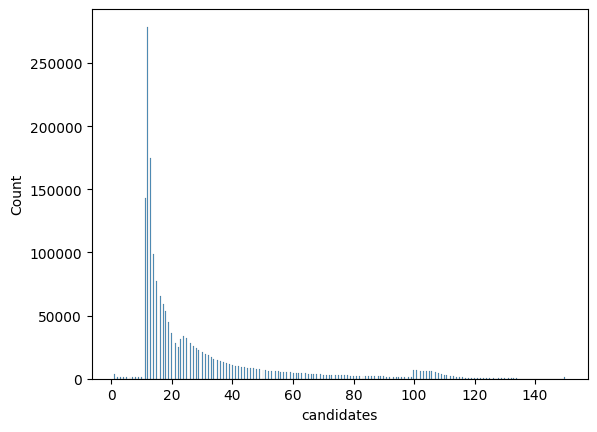

In [31]:
sns.histplot(np.clip(n_candid, 0, 150))

In [32]:
(n_candid < 20).mean()

0.5617784528641483

In [33]:
# popular = list(set(top_orders.tolist()  + top_clicks.tolist()))

# dfg["candidates"] = dfg["candidates"].apply(
#     lambda x: x if len(x) > 40 else list(set(x + popular))
# )

### Coverage

In [51]:
recalls = []
for col in CLASSES:
    if f"gt_{col}" not in dfg.columns:
        dfg = dfg.merge(gt[gt["type"] == col].drop("type", axis=1), how="left").rename(
            columns={"ground_truth": f"gt_{col}"}
        )

    n_preds, n_gts, n_found = get_coverage(
        dfg["candidates"].values, dfg[f"gt_{col}"].values
    )

    print(
        f"{col}\t- Found {numerize(n_found)} GTs with {numerize(n_preds)} candidates (pos_prop={n_found / n_preds * 100 :.2f}%)\t-  Highest reachable Recall : {n_found / n_gts :.3f}"
    )
    recalls.append(n_found / n_gts)

clicks	- Found 923K GTs with 50.63M candidates (pos_prop=1.82%)	-  Highest reachable Recall : 0.526
carts	- Found 258.84K GTs with 50.63M candidates (pos_prop=0.51%)	-  Highest reachable Recall : 0.449
orders	- Found 212.1K GTs with 50.63M candidates (pos_prop=0.42%)	-  Highest reachable Recall : 0.677


In [52]:
cv = np.average(recalls, weights=WEIGHTS)
print(f"-> Highest reachable CV : {cv:.3f}")

-> Highest reachable CV : 0.593


### Explode for saving

In [45]:
dfg.drop(["aid", "coocurence_candidates", "type"], axis=1, inplace=True)

In [56]:
dfg.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 1801251 entries, 0 to 1801250
Data columns (total 5 columns):
 #   Column      Dtype
---  ------      -----
 0   session     int64
 1   candidates  list
 2   gt_clicks   list
 3   gt_carts    list
 4   gt_orders   list
dtypes: int64(1), list(4)
memory usage: 462.1 MB


In [55]:
dfg = cudf.from_pandas(dfg)

In [57]:
df_exp = dfg.explode("candidates")

In [67]:
df_exp["candidates"] = df_exp["candidates"].astype("uint32")
df_exp["session"] = df_exp["session"].astype("uint32")

In [69]:
df_exp.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 50628692 entries, 0 to 1801250
Data columns (total 5 columns):
 #   Column      Dtype
---  ------      -----
 0   session     uint32
 1   candidates  uint32
 2   gt_clicks   list
 3   gt_carts    list
 4   gt_orders   list
dtypes: list(3), uint32(2)
memory usage: 2.1 GB


In [70]:
df_exp = df_exp.sort_values(["session", "candidates"]).reset_index(drop=True)

In [71]:
tgt_order = (
    df_exp[["session", "candidates", "gt_orders"]]
    .explode("gt_orders")
    .reset_index(drop=True)
).fillna(-1)
tgt_order["gt_orders"] = tgt_order["gt_orders"] == tgt_order["candidates"]
tgt_order = tgt_order.groupby(["session", "candidates"]).max().reset_index()
tgt_order = tgt_order.sort_values(["session", "candidates"]).reset_index(drop=True)

df_exp["gt_orders"] = tgt_order["gt_orders"].astype("uint8")

In [72]:
tgt_cart = (
    df_exp[["session", "candidates", "gt_carts"]]
    .explode("gt_carts")
    .reset_index(drop=True)
).fillna(-1)
tgt_cart["gt_carts"] = tgt_cart["gt_carts"] == tgt_cart["candidates"]
tgt_cart = tgt_cart.groupby(["session", "candidates"]).max().reset_index()
tgt_cart = tgt_cart.sort_values(["session", "candidates"]).reset_index(drop=True)

df_exp["gt_carts"] = tgt_cart["gt_carts"].astype("uint8")

In [73]:
tgt_click = (
    df_exp[["session", "candidates", "gt_clicks"]]
    .explode("gt_clicks")
    .reset_index(drop=True)
).fillna(-1)
tgt_click["gt_clicks"] = tgt_click["gt_clicks"] == tgt_click["candidates"]
tgt_click = tgt_click.groupby(["session", "candidates"]).max().reset_index()
tgt_click = tgt_click.sort_values(["session", "candidates"]).reset_index(drop=True)

df_exp["gt_clicks"] = tgt_click["gt_clicks"].astype("uint8")

In [79]:
df_exp.to_parquet(
    f"../output/candidates_val_{int(np.round(cv, 3) * 1000)}.csv", index=False
)
print(f"Saved to ../output/candidates_g_val_{int(np.round(cv, 3) * 1000)}.csv")

Saved to ../output/candidates_g_val_593.csv


Done